In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [66]:
# Load data from CSV file
data = pd.read_csv('CompleteData.csv')

In [69]:
## DATA ANALYSIS 

data = pd.read_csv('CompleteData.csv')
data = data[data['Real Estate Type'] == 'Condo Unit'] #limiting to only condo units for now
data['Price (PHP)'] = data['Price (PHP)'].str.replace(',', '').astype(float)

In [70]:
selected_columns = [ 'Highly Urbanized?','Total_area (sqm)']

# Define the target variable and feature columns
X = data[selected_columns]
y = data['Price (PHP)']

numerical_cols = ['Total_area (sqm)']
categorical_cols =['Highly Urbanized?']

# Preprocessing for numerical data
numerical_transformer = StandardScaler()
# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [71]:
## REGRESSION MODEL
regressor = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=200, random_state=123)
#regressor = xgb.XGBRegressor(n_estimators=10000, random_state=42)

# Preprocessing and training pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 2868009.872241299
Mean Squared Error: 26965503312142.51
Root Mean Squared Error: 5192831.916415407


In [72]:
## Test with input 

test_point = pd.DataFrame({'Real Estate Type': ['Condo Unit'], 'Highly Urbanized?': [1], 'City': ['Taguig'], 'Total_area (sqm)': [168]})

# Make prediction
prediction = model.predict(test_point)

print(f'Predicted price for the test point: {prediction[0]}')


Predicted price for the test point: 47961831.75018037


In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

# Predict and evaluate
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


C:\Users\59cha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
363 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\59cha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\59cha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

In [74]:
## Test with input 

test_point = pd.DataFrame({'Real Estate Type': ['Condo Unit'], 'Highly Urbanized?': [1], 'City': ['Taguig'], 'Total_area (sqm)': [168]})

# Make prediction
prediction = model.predict(test_point)

print(f'Predicted price for the test point: {prediction[0]}')

Predicted price for the test point: 47961831.75018037


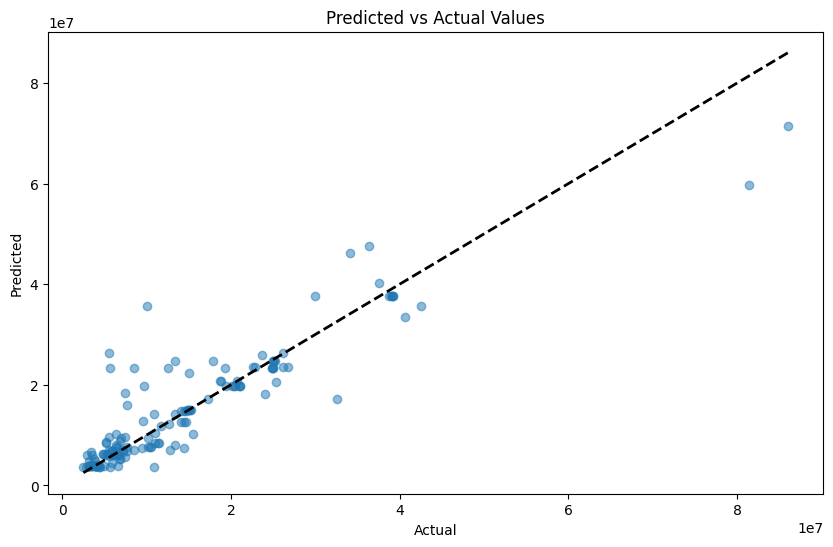

In [75]:
# Predicted vs Actual Values Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Values')
plt.show()

               Feature  Importance
0     Total_area (sqm)    0.962543
1  Highly Urbanized?_0    0.019282
2  Highly Urbanized?_1    0.018175


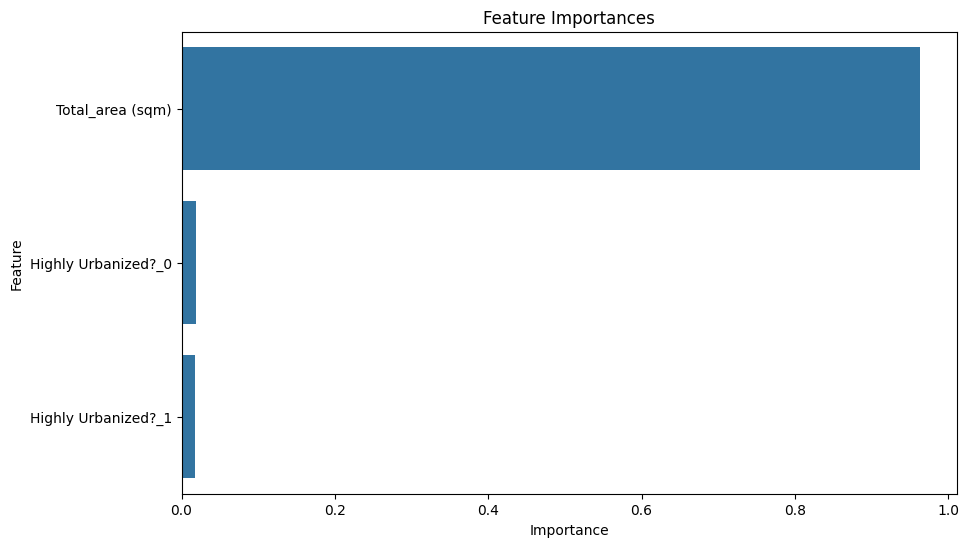

In [76]:
# Feature importance
feature_importances = model.named_steps['regressor'].feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': numerical_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist(),
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importances_df.head())

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.show()

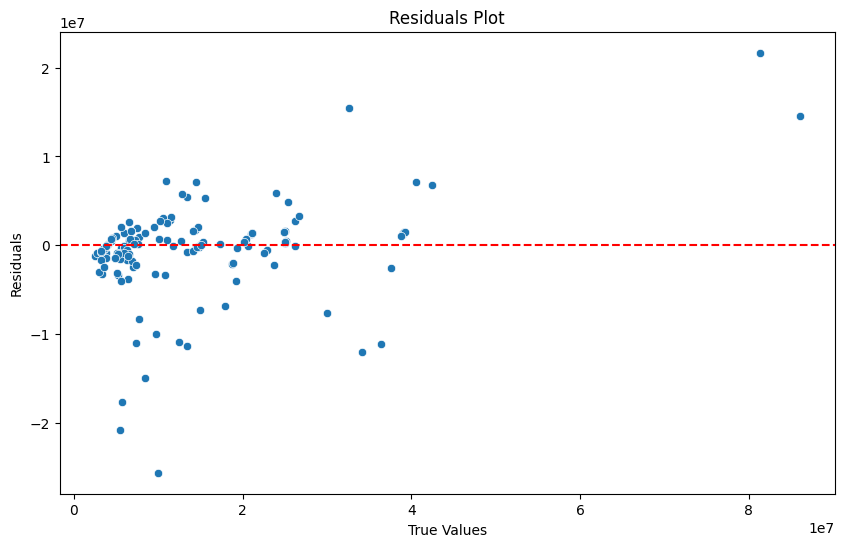

In [77]:
# Residuals plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()